Problem Set 8: Network Flow and Bipartite Matching
========================



In [ ]:
# You may need to `pip install networkx` and `pip install numpy`
# We'll use NetworkX as in problem set 3 and 5.
import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html

import numpy as np

#Visualization tools
import pylab
import matplotlib
%matplotlib inline
import matplotlib.patches as patches

In [ ]:
# Somehow, this setting gets overridden if it's placed in the previous code block.
# If someone can explain this curious behavior to me, I'd appreciate it. =)

matplotlib.rcParams['figure.figsize'] = (10,10)

Network Flow Code
--------------------

In [ ]:
def find_path(residual, s, t):
    """Find the shortest s->t path over nonzero edges in residual graph."""
    # Remove zero-weight edges, and use a copy so we don't change the graph
    r = residual.copy()
    r.remove_edges_from([e for e in r.edges if
                         r.edges[e]['c'] == 0])
    # and find the shortest path      
    try:
        return nx.shortest_path(r, s, t)
    except nx.exception.NetworkXNoPath:
        return None

def max_flow(G, s, t):
    """Find the maximum s-t flow in a graph via Ford-Fulkerson.
    
    G.edges[(u,v)]['c'] denotes the capacity of the u->v edge.
    
    Return a dictionary of the flows where
      flow[(u,v)] = flow from u->v in a max flow solution.
    """
    residual = G.copy()
    while True:
        augmenting_path = find_path(residual, s, t)
        if augmenting_path is None:
            break
            
        # Find the capacity along the path
        path_edges = list(zip(augmenting_path[:-1], augmenting_path[1:]))
        path_capacities = [residual.edges[e]['c'] for e in path_edges]
        flow_this_round = min(path_capacities)
        #Subtract from forward edges, add to reverse
        for u,v in path_edges:
            residual.edges[(u,v)]['c'] -= flow_this_round
            if (v,u) not in residual.edges:
                residual.add_edge(v,u, c=0)
            residual.edges[(v,u)]['c'] += flow_this_round

    # Part (a): Oops! We forgot to actually compute the `flow`
    # dictionary.  Rectify this.
    ...
    return flow

Tiling Problem
-----------------

We now solve the following problem.  You are given a subset of squares in a grid.  You want to place as many dominoes (= 2x1 tiles) on this subset as possible, without overlaps.

In [ ]:
def random_mask(r, c, p):
    return np.random.random(size=(r,c)) > p

def draw_rectangle(lx, ly, widthx, widthy, **kws):
    pylab.gca().add_patch(patches.Rectangle((lx, ly), widthx, widthy,
                                           **kws))

def display_tiling_problem(mask):
    r, c = mask.shape
    for i in range(r):
        for j in range(c):
            if mask[i][j]:
                draw_rectangle(i, j, 1, 1, lw=1, ec='black')
    pylab.xlim(0, r)
    pylab.ylim(0, c)
                
m = random_mask(10, 10, 0.3)
pylab.figure(figsize=(5,5))
display_tiling_problem(m)
    

In [ ]:
def matching_graph_for_tiling_mask(mask):
    r, c = mask.shape
    G = nx.DiGraph()
    G.add_nodes_from((a,b) for a in range(r) for b in range(c)
                     if mask[a][b])
    G.add_nodes_from(['s', 't'])
    adjacencies = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    for u in G.nodes:
        if u in ['s', 't']:
            continue
        i, j = u
        if (i + j) % 2 == 0:
            G.add_edge(u, 't', c=1)
        else:
            G.add_edge('s', u, c=1)
            for dx, dy in adjacencies:
                v = (i + dx, j + dy)
                if v in G.nodes:
                    G.add_edge(u, v, c=1)
    return G

G = matching_graph_for_tiling_mask(m)
            

In [ ]:
f = max_flow(G, 's', 't')
total_flow = sum(f[e] for e in f if e[0] == 's')
print("Found solution with total flow", total_flow)
# This should work, and find positive flow

In [ ]:
def display_tiling_solution(mask, pairs):
    display_tiling_problem(mask)
    for (u,v) in pairs:
        if u == 's' or v == 't':
            continue
        pylab.plot([u[0] + .5, v[0]+ .5], [u[1]+ .5, v[1]+ .5], 'k',
                  lw=10)
    
pylab.figure(figsize=(5,5))
display_tiling_solution(m, [k for k in f.keys() if f[k] > 0])
#This should display the associated tiling

In [ ]:
# Let's compare to a greedy solution.
# (Sometimes the greedy works by chance.)

def greedy_tiling(mask):
    mask = mask.copy()
    tiles = set()
    adjacencies = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    r, c = mask.shape
    for i in range(r):
        for j in range(c):
            if mask[i][j]:
                for dx, dy in adjacencies:
                    v = (i+dx, j+dy)
                    if 0 <= v[0] < r and 0 <= v[1] < c:
                        if mask[v[0]][v[1]]:
                            tiles.add(((i,j), v))
                            mask[i][j] = mask[v[0]][v[1]] = 0
                            break
    return tiles

greedy_result = greedy_tiling(m)
print("Greedy tiling:", len(greedy_result))
pylab.figure(figsize=(5,5))
display_tiling_solution(m, greedy_result)


In [ ]:
# Let's run the greedy and net flow solutions side by side.
# Rerun this until the two perform differently.

m = random_mask(15, 15, 0.25)
G = matching_graph_for_tiling_mask(m)
f = max_flow(G, 's', 't')
total_flow = sum(f[e] for e in f if e[0] == 's')
greedy_result = greedy_tiling(m)
print("Net flow:", total_flow, 'vs greedy:', len(greedy_result))
pylab.figure(figsize=(10,5))
pylab.subplot(121)
display_tiling_solution(m, [k for k in f.keys() if f[k] > 0])
pylab.subplot(122)
display_tiling_solution(m, greedy_result)


Part (b): Set Selection
================

In this part we consider the _set selection_ problem.  See the following image:

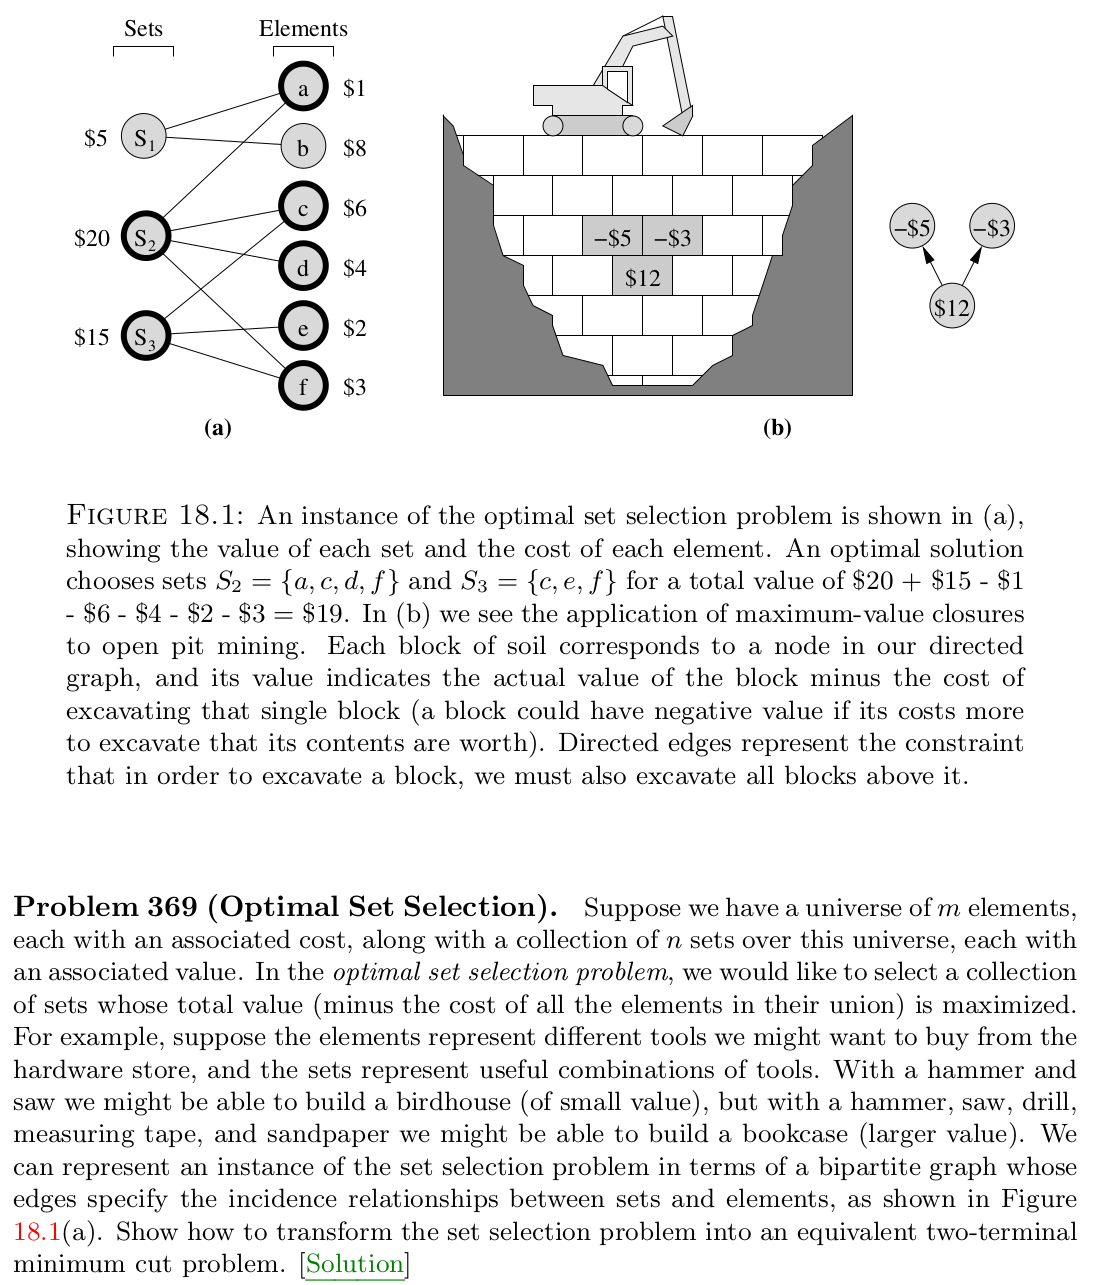

In [ ]:
def set_selection_value(V, C, Ss):
    """ Return the value of the optimal set-selection solution.
    
    V  is a list of m values of items
    C  is a list of n costs of tools
    Ss is a list of m sets, where the i-th set denotes the tools
       required to produce the i-th item. 
       It is a subset of {0, ..., n-1}
      
    You would like a set T of items that maximizes
    
      (sum_{u in T} V_u) - (sum_{v in R} C_v)
     where R = union_{i in T} Ss[i] is the required tools.
          
    For this problem, just output the value of the solution.
    """
    G = nx.DiGraph()
    ... # Write me!
    return value

# Example from the book
V = [5, 20, 15]
C = [1, 8, 6, 4, 2, 3]
Ss = [[0,1], [0,2,3,5], [2,4,5]]

print(set_selection_value(V, C, Ss), 'should be 19')

In [ ]:
# Now rewrite the previous part to output the set T.

def set_selection(V, C, Ss):
    G = nx.DiGraph()
    ... # Write me!
    return T
    
print(set_selection(V, C, Ss), 'should be [1,2]')

# and a slightly harder instance
V2 = [5, 10, 10, 15]
C2 = [1, 8, 6, 4, 2, 3]
Ss2 = [[0,1], [0,2,3,5], [0,2,3,5], [2,4,5]]
print(set_selection(V2, C2, Ss2), 'should be [1,2,3]')
